# Imports

In [ ]:
!pyenv virtualenv 3.11.9 atari-venv --system-site-packages
!pip install "gymnasium[box2d, atari, accept-rom-license]"
!pip install moviepy
!pip install matplotlib
!pip install install tensorflow[and-cuda]

In [30]:
import numpy as np
import gymnasium as gym
import tensorflow as tf
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2024-04-29 23:52:04.319875: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-29 23:52:04.346876: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-29 23:52:04.346988: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Environment

Create the environment. You can use any ATARI environment from [here](https://gymnasium.farama.org/environments/atari/), but prefer to use environments with discrete action space with fewer actions.

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/home/mimisha/.pyenv/versions/atari-venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


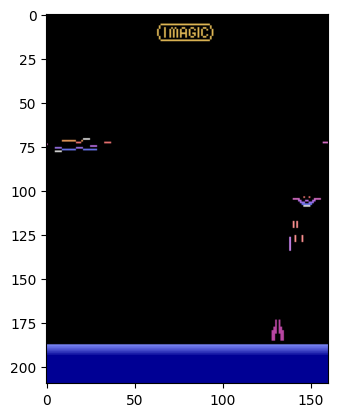

In [3]:
env = gym.make('ALE/DemonAttack-v5', render_mode='rgb_array')
eval_env = gym.make('ALE/DemonAttack-v5')
env.reset()
plt.imshow(env.render())

In [46]:
env.action_space.__dict__.keys()

dict_keys(['n', 'start', '_shape', 'dtype', '_np_random'])

In [24]:
(60, *env.observation_space._shape)

(60, 210, 160, 3)

# Replay Buffer

Create a replay buffer to hold game history

In [16]:
class ReplayBuffer:

    def __init__(self, max_size: int, observation_space: gym.spaces.Space, action_space: gym.spaces.Space, seed: int | None = None):
        """Stores the replay history with a maximum of `max_size` entries, removing old entries as needed.

        Parameters:
            max_size: maximal number of entries to keep
            observation_space: specification of the observation space
            action_space: specification of the action space
            seed: seed to initialize the internal random number generator for reproducibility"""
        self.max_size = max_size
        self.observation_space = observation_space
        self.action_space = action_space
        self.seed = seed
        self.rng = np.random.default_rng(seed=seed)
        
        self.current_state = np.zeros((max_size, *observation_space.shape))
        
        self.action = np.zeros(max_size, dtype=int)
        self.reward = np.zeros(max_size)
        self.next_state = np.zeros_like(self.current_state)
        self.done = np.zeros(max_size)
        
        self.step = 0
        self.len = 0
        
    def add(self, current_observation: np.ndarray, action: int, reward: float, next_observation: np.ndarray, done: bool) -> None:
        """Add a new entry to the buffer.

        Parameters:
            current_observation: environment state observed at the current step
            action: action taken by the model
            reward: reward received after taking the action
            next_observation: environment state obversed after taking the action
            done: whether the episode has ended or not"""
        self.current_state[self.step] = current_observation
        self.action[self.step] = action
        self.reward[self.step] = reward
        self.next_state[self.step] = next_observation
        self.done[self.step] = done
        self.step = (self.step + 1) % self.max_size
        self.len = min(self.len + 1, self.max_size)
        
    def sample(self, n_samples: int, replace: bool = True) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """Randomly samples `n_samples` from the buffer.

        Parameters:
            n_samples: number of samples to select
            replace: sample with or without replacement

        Returns:
            current observations, actions, rewards, next observations, done"""
        indicies = self.rng.choice(self.len, size=n_samples)
        return (
            self.current_state[indicies], 
            self.action[indicies], 
            self.reward[indicies], 
            self.next_state[indicies], 
            self.done[indicies]
        )

    def clear(self) -> None:
        """Clears the buffer"""
        self.step = self.len = 0

    def __getitem__(self, index: int) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """Gets a sample at `index`

        Parameters:
            index: index of the sample to get

        Returns:
            current observation, action, reward, next observation, done"""
        return (
            self.current_state[index], 
            self.action[index], 
            self.reward[index], 
            self.next_state[index], 
            self.done[index]
        )
        
    def __len__(self) -> int:
        """Returns the number of entries in the buffer"""
        return self.len

# Model

Implement your model. Most if not all ATARI environments have an image observation

In [38]:
def get_name(prefix: str | None = None, suffix: str | None = None, separator: str = '_') -> str | None:
    if prefix is None:
        return suffix
    return prefix and prefix + separator + suffix or suffix or None

In [40]:
def convBlock(filters: int, filter_size: int, inputs, number: int):
    local = tf.keras.layers.Conv2D(filters, filter_size, padding="same", kernel_initializer="he_normal", 
                                           kernel_regularizer=l2(1e-4), name=get_name(suffix=f'conv_bloc_{number}'))(inputs)
    local = tf.keras.layers.PReLU()(local)
    local = tf.keras.layers.BatchNormalization()(local)
    return local

In [28]:
def get_model(
    input_features: tuple, 
    out_features: int,
    blocks: int, 
    activation: str | tf.keras.layers.Activation | None = 'silu',
    dropout: float = 0.,
    kernel_num: int = 32,
    multiply_freq: int = 2,
    name: str | None = None
) -> tf.keras.Model:
    inputs = x = tf.keras.layers.Input(input_features, name=get_name(name, 'input'))

    for i in range(blocks):
        # position, velocity, angle, angle velocity
        x = convBlock(kernel_num, 7, inputs, i)
        x = tf.keras.layers.MaxPooling2D()(x)
        if dropout > 0:
            x = tf.keras.layers.Dropout(dropout, name=get_name(name, f'dropout_{i}'))(x)

        if multiply_freq > 0 and (i + 1) % multiply_freq == 0:
            kernel_num *= 2

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(out_features, name=get_name(name, 'prediction'))(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x, name=name)

In [48]:
model = get_model(env.observation_space._shape, out_features=env.action_space.n, blocks=3, name="my_model")
model.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ my_model_input (InputLayer)     │ (None, 210, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_bloc_2 (Conv2D)            │ (None, 210, 160, 64)   │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_5 (PReLU)               │ (None, 210, 160, 64)   │     2,150,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 210, 160, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 105, 80, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ my_model_prediction (Dense)     │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,160,518 (8.24 MB)

 Trainable params: 2,160,390 (8.24 MB)

 Non-trainable params: 128 (512.00 B)

In [47]:
env.action_space.n

6

# Sampler

Implement the sampler

In [ ]:
class Sampler:
    
    def __init__(self, epsilon: float, seed: int | None = None):
        """Selects a random action with probability `epsilon` otherwise selects the most probably action given by the model.

        Parameters:
            epsilon: the probability to select a random action
            seed: seed to initialize the internal random number generator for reproducibility"""
        ...
        
    def __call__(self, probabilities: np.ndarray) -> int:
        """Select an action given the `probabilities

        Parameters:
            probabilities: probabilities for each action

        Returns:
            index of the selected action"""
        ...

# Play the game

Implement interacting with the environment and storing entries to the replay buffer

In [ ]:
def play_game(model: tf.keras.Model, buffer: ReplayBuffer | None, env: gym.Env, max_steps: int, sampler: Sampler, observation: np.ndarray | None = None) -> np.ndarray:
    """Play game and record

    Parameters:
        model: the model to get actions with
        buffer: replay buffer to store the entries to
        env: environment to play
        max_steps: maximal number of steps to perform
        sampler: sampler to use to sample actions
        observation: the observation to resume from

    Returns:
        the last observation"""
    ...

# Loss

Implement double q learning loss

In [ ]:
def qq_loss(
    current_observation: tf.Tensor, 
    action: tf.Tensor, 
    reward: tf.Tensor, 
    next_observation: tf.Tensor, 
    done: tf.Tensor,
    model: tf.keras.Model,
    target_model: tf.keras.Model,
    gamma: float
) -> tf.Tensor:
    """Computes double q learning loss.

    Parameters:
        current_observation: observations at the current time step
        action: actions taken at the current time step
        reward: rewards at the current time step
        next_observation: observations at the next time step
        done: whether the episode has ended or not
        model: trainig model
        target_model: target model
        gamme: discount

    Returns:
        Computed loss"""
    ...

# Training

Create models, replay buffers, sampler, optimizer, epsilon decay etc. Implement training loop, show training progress and perform model evaluation once in a while

# Testing

Test the model on the environment and get a cool video